In [1]:
import numpy as np
import pandas as pd
import scipy.signal

In [6]:

out_dir =  '/liberatrix/mcintosh_lab/jwang/ModelFitting/simData_Fr/DecoAdam/'
ts_base_dir='/gerda/mcintosh_lab/jgriffiths/hcp_wuminn_l2k8_rsfmri_ts/data/results/'
ts_file = ts_base_dir+sub+'_rfMRI_REST1_LR_hpc200_clean__l2k8_sc33_ts.pkl'
ts_df = pd.read_pickle(ts_file)
ts = ts_df.values

def get_EI(sub, out_dir):
    train_E=np.loadtxt(out_dir+'HCP_'+sub+'sim_fitting_E_test.txt')
    train_I=np.loadtxt(out_dir+'HCP_'+sub+'sim_fitting_I_test.txt')

    test_E=np.loadtxt(out_dir+'HCP_'+sub+'sim_E_test.txt')
    test_I=np.loadtxt(out_dir+'HCP_'+sub+'sim_I_test.txt')
    return train_E, train_I, test_E, test_I

In [7]:
def plot_manifold_EI(sub, train_E, train_I, test_E, test_I, x_l, x_h, y_l, y_h):
    fig, ax=plt.subplots(1,2)
    ax[0].scatter(train_E.mean(1)[10:], train_I.mean(1)[10:], alpha=0.02)
    ax[0].set_xlim([x_l, x_h])
    ax[0].set_ylim([y_l, y_h])
    ax[1].scatter(test_E.mean(1)[50:], test_I.mean(1)[50:], alpha=0.01)
    ax[1].set_xlim([x_l, x_h])
    ax[1].set_ylim([y_l, y_h])
    plt.suptitle("Manifold of E and I: sub_"+ sub)
    plt.show()
    

In [8]:
import matplotlib.pyplot as plt

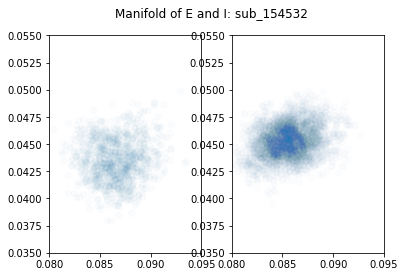

In [9]:
sub='154532'
x_l =0.08
x_h =0.095
y_l = 0.035
y_h=0.055
train_E, train_I, test_E, test_I = get_EI(sub, out_dir)
plot_manifold_EI(sub, train_E, train_I, test_E, test_I, x_l, x_h, y_l, y_h)

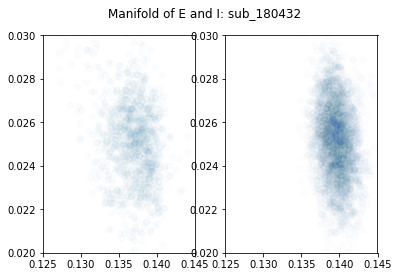

In [63]:
sub='180432'
x_l =0.125
x_h =0.145
y_l = 0.02
y_h=0.03
train_E, train_I, test_E, test_I = get_EI(sub, out_dir)
plot_manifold_EI(sub, train_E, train_I, test_E, test_I, x_l, x_h, y_l, y_h)

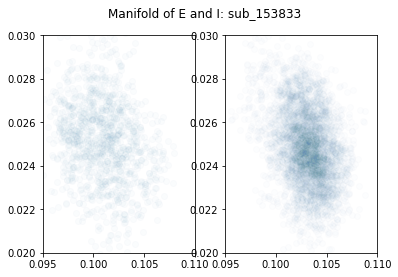

In [65]:
sub='153833'
x_l =0.095
x_h =0.11
y_l = 0.02
y_h=0.03
train_E, train_I, test_E, test_I = get_EI(sub, out_dir)
plot_manifold_EI(sub, train_E, train_I, test_E, test_I, x_l, x_h, y_l, y_h)

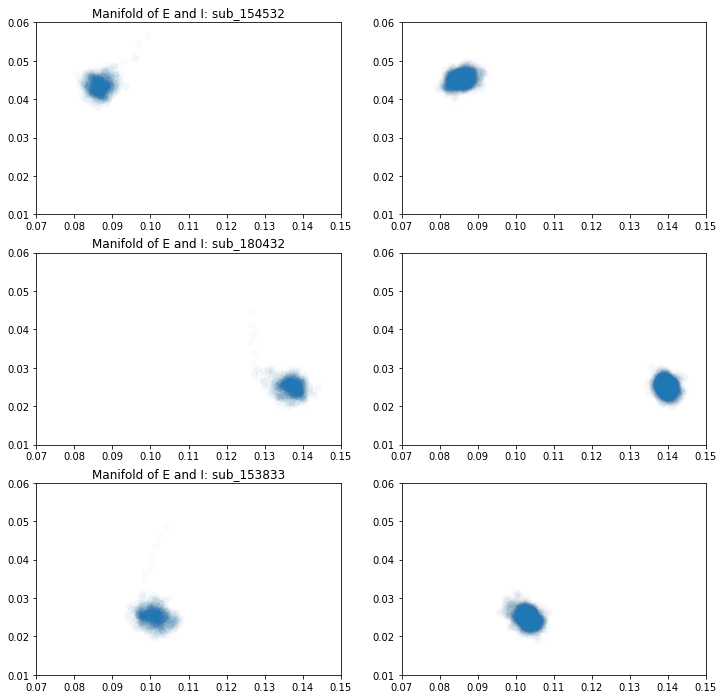

In [48]:
subs=['154532','180432','153833']
fig, ax=plt.subplots(3,2, figsize=(12,12))
i_n=0
for sub in subs:
    train_E=np.loadtxt(out_dir+'HCP_'+sub+'sim_fitting_E_test.txt')
    train_I=np.loadtxt(out_dir+'HCP_'+sub+'sim_fitting_I_test.txt')

    test_E=np.loadtxt(out_dir+'HCP_'+sub+'sim_E_test.txt')
    test_I=np.loadtxt(out_dir+'HCP_'+sub+'sim_I_test.txt')
    
    
    ax[i_n,0].scatter(train_E.mean(1)[10:], train_I.mean(1)[10:], alpha=0.02)
    ax[i_n, 0].set_xlim([0.07, 0.15])
    ax[i_n, 0].set_ylim([0.01, 0.06])
    
    ax[i_n,1].scatter(test_E.mean(1)[50:], test_I.mean(1)[50:], alpha=0.01)
    ax[i_n, 1].set_xlim([0.07, 0.15])
    ax[i_n, 1].set_ylim([0.01, 0.06])
    
    ax[i_n, 0].set_title("Manifold of E and I: sub_"+ sub)
    i_n += 1
plt.show()
    

In [10]:
from sklearn.cluster import KMeans

##### steps
step 1 get analytical signal
     E + Ij or get hilbert from empirical BOLD
step 2 at each ROI and each time-point
     get angle (phase) -pi to pi
step 3 at each time-point
     get cos similairty matrix
step 4 at each time-point
     svd to get 1st or 2nd eigenvector
step 5 put all the eigenvectors into a bad and cluster them using k-mean




In [62]:


def get_leads_ts(analytic_signal, n_ev):
    phase=np.angle(analytic_signal)
    #phase=np.unwrap(np.angle(analytic_signal))
    Leads = []
    for i in range(phase.shape[0]):
        FC_inst=np.cos(phase[i:i+1,:].T-phase[i:i+1,:])
        FC_inst=FC_inst.T
        w, v =np.linalg.eigh(FC_inst)
        #print(w[-2:])
        Leads.append(v[:,-n_ev].ravel())
    return Leads
    

In [63]:

def leads_train(X, n_clusters):
    
    
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(X)
    labels = kmeans.labels_
    centers = kmeans.cluster_centers_
    return labels, centers

In [64]:
### cluster using the 2nd eigenvector

sub='154532'
out_dir =  '/liberatrix/mcintosh_lab/jwang/ModelFitting/simData_Fr/DecoAdam/'
ts_base_dir='/gerda/mcintosh_lab/jgriffiths/hcp_wuminn_l2k8_rsfmri_ts/data/results/'
ts_file = ts_base_dir+sub+'_rfMRI_REST1_LR_hpc200_clean__l2k8_sc33_ts.pkl'
ts_df = pd.read_pickle(ts_file)
ts = ts_df.values
analytic_signal_exp = scipy.signal.hilbert(ts,axis=0)

Leads_exp = get_leads_ts(analytic_signal_exp, 1)

X_exp = np.array(Leads_exp)
labels_exp, centers_exp= leads_train(X_exp, 3)

train_E, train_I, test_E, test_I = get_EI(sub, out_dir)
analytic_signal_trained = train_E +train_I*1j#scipy.signal.hilbert(ts,axis=0)
Leads_trained_2nd = get_leads_ts(analytic_signal_trained, 2)

X_trained_2nd = np.array(Leads_trained_2nd)
labels_trained_2nd, centers_trained_2nd = leads_train(X_trained_2nd, 3)

analytic_signal_test= test_E +test_I*1j#scipy.signal.hilbert(ts,axis=0)
Leads_test_2nd = get_leads_ts(analytic_signal_test, 2)

X_test_2nd = np.array(Leads_test_2nd)
labels_test_2nd, centers_test_2nd = leads_train(X_test_2nd, 3)


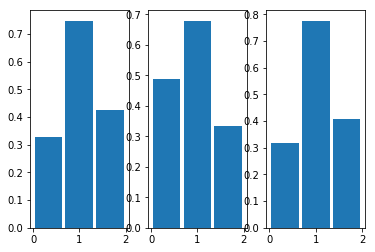

In [65]:
#### histogram of clusters

import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,3)
ax[0].hist(labels_trained_2nd,bins=3, rwidth=0.9, density=True)
ax[1].hist(labels_exp, bins =3, rwidth=0.9, density=True)
ax[2].hist(labels_test_2nd, bins =3, rwidth=0.9, density=True)
plt.show()

In [66]:
np.corrcoef(np.vstack((centers_exp,centers_trained_2nd)))[:3,:][:,3:]

array([[ 0.38248048, -0.57421744,  0.37081585],
       [-0.53285978,  0.54063861, -0.56890224],
       [-0.23531035,  0.13429973, -0.10724342]])

In [67]:
np.corrcoef(np.vstack((centers_test_2nd,centers_trained_2nd)))[:3,:][:,3:]

array([[-0.55198983,  0.90793687, -0.88510587],
       [ 0.80959552, -0.84606318,  0.86164115],
       [-0.71207782,  0.72378971, -0.47866013]])

In [68]:
np.corrcoef(np.vstack((centers_exp,centers_test_2nd)))[:3,:][:,3:]

array([[-0.47216335,  0.46355451, -0.67919658],
       [ 0.4902358 , -0.71139758,  0.67988383],
       [ 0.07003343, -0.17996788,  0.13487328]])

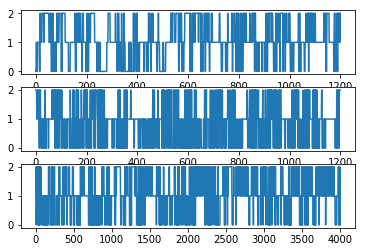

In [69]:
#### time series of clusters


fig, ax = plt.subplots(3,1)
ax[0].plot(labels_trained_2nd)
ax[1].plot(labels_exp)
ax[2].plot(labels_test_2nd)
plt.show()

In [70]:
centers_test_2nd[0]

array([ 0.06623343, -0.01949356,  0.03772009,  0.00138406, -0.02568633,
       -0.02796944, -0.02076839, -0.01154414, -0.01011188, -0.04079349,
       -0.02008171,  0.02972263,  0.01044962, -0.00291758, -0.01566199,
       -0.01110127, -0.02513324, -0.00983649, -0.02239059, -0.01746186,
       -0.01067364, -0.02678172, -0.02790039, -0.01476525, -0.02940081,
        0.01542789,  0.03490655,  0.00271338, -0.00679194, -0.02294215,
       -0.01982986, -0.0098035 ,  0.05371588, -0.02788894, -0.00894671,
        0.00828869, -0.033727  ,  0.07944278,  0.0594332 ,  0.02480005,
        0.02284718,  0.00937755, -0.00599102,  0.0117136 ,  0.0386679 ,
       -0.02251891, -0.01829692, -0.02409864, -0.032593  , -0.00559298,
       -0.03078474, -0.01947433,  0.03653767,  0.01496336,  0.03458131,
        0.00183471, -0.03811274, -0.02579799, -0.03420992, -0.03721635,
       -0.03506546, -0.0336479 , -0.03981152, -0.03016328, -0.0312997 ,
       -0.03369311,  0.0271299 ,  0.041985  ,  0.0436563 , -0.03

In [71]:
centers_test_2nd[1]

array([ 0.0775649 ,  0.00570197, -0.04148433, -0.02143206,  0.02869701,
        0.01434588,  0.01202217,  0.02111692,  0.008964  ,  0.0224896 ,
        0.01881292, -0.02054622, -0.01484139, -0.00914114,  0.00044341,
        0.01632187,  0.01630214,  0.02259611,  0.01956405,  0.01539311,
        0.01647068,  0.01423101,  0.03088503,  0.02112637,  0.0216015 ,
       -0.0252273 , -0.05095336, -0.03095449,  0.01199774,  0.01044234,
        0.01672981,  0.02575613, -0.10582731,  0.03262889,  0.02270566,
       -0.01992861,  0.02510818, -0.1148412 , -0.07006996, -0.01752721,
       -0.03262157, -0.02143825, -0.00126075, -0.0507507 , -0.03136535,
        0.01223516,  0.02320728,  0.01896544,  0.0196825 ,  0.01818002,
        0.03468844,  0.01812029, -0.03250299, -0.0055386 , -0.02881345,
       -0.01476746,  0.02622717,  0.03227056,  0.03096893,  0.02903864,
        0.03641484,  0.02706539,  0.02728736,  0.02481443,  0.02129388,
        0.03122144, -0.02872192, -0.05095446, -0.05062553,  0.03

In [72]:
centers_test_2nd[2]

array([ 0.08274251,  0.02035252,  0.03667634,  0.02938594, -0.02917634,
       -0.01440146, -0.00488442, -0.02379361, -0.03179941, -0.02461044,
       -0.02425654,  0.00529686,  0.00119017, -0.00057484,  0.00180322,
       -0.02666285, -0.0257166 , -0.03547237, -0.018796  , -0.02069504,
       -0.02293226, -0.02076574, -0.02344693, -0.0286124 , -0.0218846 ,
        0.00918455,  0.05128472,  0.03709489, -0.01930676, -0.00659174,
        0.00212791, -0.02305325,  0.13252913, -0.02700032, -0.02839062,
        0.0262398 , -0.01790178,  0.10171242,  0.06497239,  0.0412052 ,
        0.0151229 ,  0.02185282, -0.01053076,  0.05299111,  0.02768358,
       -0.00935235, -0.03419282, -0.03516684, -0.02876896, -0.0218413 ,
       -0.02318101, -0.02204948,  0.02261644,  0.02275136,  0.06004218,
        0.03728034, -0.03320626, -0.02462497, -0.03535708, -0.03894116,
       -0.02780347, -0.01987681, -0.02482547, -0.02533328, -0.02552666,
       -0.02510737,  0.0421909 ,  0.03403797,  0.06256809, -0.03

In [73]:
### cluster using the first eigenvector 

sub='154532'
out_dir =  '/liberatrix/mcintosh_lab/jwang/ModelFitting/simData_Fr/DecoAdam/'
ts_base_dir='/gerda/mcintosh_lab/jgriffiths/hcp_wuminn_l2k8_rsfmri_ts/data/results/'
ts_file = ts_base_dir+sub+'_rfMRI_REST1_LR_hpc200_clean__l2k8_sc33_ts.pkl'
ts_df = pd.read_pickle(ts_file)
ts = ts_df.values
analytic_signal_exp = scipy.signal.hilbert(ts,axis=0)

Leads_exp = get_leads_ts(analytic_signal_exp, 1)

X_exp = np.array(Leads_exp)
labels_sim, centers_sim = leads_train(X_exp, 3)

train_E, train_I, test_E, test_I = get_EI(sub, out_dir)
analytic_signal_trained = train_E +train_I*1j#scipy.signal.hilbert(ts,axis=0)
Leads_trained = get_leads_ts(analytic_signal_trained, 1)

X_trained = np.array(Leads_trained)
labels_trained, centers_trained = leads_train(X_trained, 3)

analytic_signal_test= test_E +test_I*1j#scipy.signal.hilbert(ts,axis=0)
Leads_test = get_leads_ts(analytic_signal_test, 1)

X_test = np.array(Leads_test)
labels_test, centers_test = leads_train(X_test, 3)


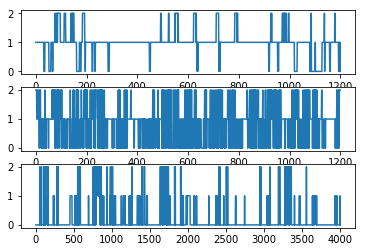

In [74]:
#### time series of clusters


fig, ax = plt.subplots(3,1)
ax[0].plot(labels_trained)
ax[1].plot(labels_exp)
ax[2].plot(labels_test)
plt.show()

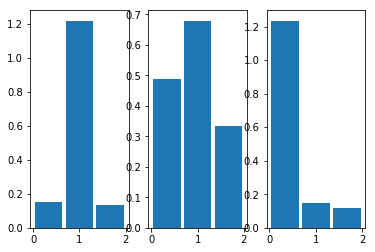

In [75]:
#### histogram of clusters

import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,3)
ax[0].hist(labels_trained,bins=3, rwidth=0.9, density=True)
ax[1].hist(labels_exp, bins =3, rwidth=0.9, density=True)
ax[2].hist(labels_test, bins =3, rwidth=0.9, density=True)
plt.show()

In [76]:
np.corrcoef(np.vstack((centers_test,centers_trained)))[:3,:][:,3:]

array([[0.43975042, 0.9453989 , 0.45226563],
       [0.23996086, 0.51274641, 0.99076603],
       [0.98690515, 0.65938784, 0.19418253]])

In [77]:
centers_test[0]

array([-0.10995948, -0.10988689, -0.10925156, -0.10953025, -0.11008043,
       -0.11015295, -0.1101462 , -0.11018928, -0.1101131 , -0.11015583,
       -0.1101179 , -0.1095818 , -0.1096851 , -0.10986598, -0.10990856,
       -0.11014614, -0.11018224, -0.11005992, -0.11014878, -0.11019087,
       -0.11021232, -0.11004158, -0.11010083, -0.11008194, -0.11002225,
       -0.10939795, -0.10901486, -0.10947539, -0.10995828, -0.11013885,
       -0.1101334 , -0.11002077, -0.10707512, -0.11000089, -0.11012538,
       -0.10915566, -0.11004046, -0.10666408, -0.10871747, -0.10964027,
       -0.10907329, -0.10971727, -0.11000839, -0.10905582, -0.10939314,
       -0.11018054, -0.11016196, -0.11015873, -0.11024174, -0.11021732,
       -0.1101164 , -0.11009556, -0.10927642, -0.1097483 , -0.10950359,
       -0.10977009, -0.1100902 , -0.11007725, -0.11008728, -0.11017136,
       -0.11010555, -0.11024353, -0.11011482, -0.11017829, -0.11012758,
       -0.11008851, -0.10949667, -0.10935674, -0.10928561, -0.11

In [78]:
centers_test[1]

array([-0.11054793, -0.11031584, -0.10895474, -0.10996735, -0.11030028,
       -0.11059614, -0.11049275, -0.11028732, -0.1104105 , -0.110389  ,
       -0.1103823 , -0.10967085, -0.10995848, -0.11030448, -0.11015575,
       -0.1103823 , -0.11052573, -0.11046457, -0.11050592, -0.11039315,
       -0.11055448, -0.11038902, -0.11051967, -0.11056969, -0.1103074 ,
       -0.1097132 , -0.10871661, -0.10999106, -0.11041495, -0.11040878,
       -0.11039013, -0.11026588, -0.10781355, -0.11038539, -0.11029487,
       -0.10967828, -0.11000074, -0.10646713, -0.10912704, -0.10991163,
       -0.109128  , -0.10977371, -0.11018697, -0.10914863, -0.10980531,
       -0.1103138 , -0.11063436, -0.11040431, -0.11020251, -0.11038288,
       -0.11034135, -0.1105462 , -0.10940334, -0.11022385, -0.10946991,
       -0.11012634, -0.11032378, -0.11043533, -0.11025852, -0.11047874,
       -0.11035386, -0.11047255, -0.11038096, -0.11047691, -0.11028759,
       -0.11049227, -0.10932802, -0.10956617, -0.10978894, -0.11

In [79]:
centers_test[2]

array([-0.11045872, -0.11017788, -0.10856687, -0.10988191, -0.11044036,
       -0.11033317, -0.11062852, -0.11062427, -0.11059227, -0.11062986,
       -0.11052369, -0.11011938, -0.11016863, -0.11019357, -0.11032415,
       -0.11059079, -0.1103293 , -0.11053869, -0.11064064, -0.11040157,
       -0.11056292, -0.11049195, -0.11051317, -0.11061302, -0.11054643,
       -0.11021296, -0.10940978, -0.10973355, -0.11043847, -0.11047079,
       -0.11038027, -0.1103684 , -0.10358161, -0.11046296, -0.11049027,
       -0.10922236, -0.11034938, -0.10747352, -0.10871635, -0.11008094,
       -0.10924274, -0.11016573, -0.1103219 , -0.10951012, -0.11011949,
       -0.11038075, -0.11051744, -0.11062165, -0.11034218, -0.11062598,
       -0.11022726, -0.11035054, -0.10956445, -0.1103695 , -0.11013314,
       -0.11041852, -0.11035957, -0.10986628, -0.11019207, -0.1104611 ,
       -0.11062572, -0.11072203, -0.1104731 , -0.11046675, -0.11038585,
       -0.11056802, -0.10933839, -0.10981255, -0.10997114, -0.11

In [99]:
#### comparison between subjects
sub='154532'
out_dir =  '/liberatrix/mcintosh_lab/jwang/ModelFitting/simData_Fr/DecoAdam/'

train_E_1, train_I_1, test_E_1, test_I_1 = get_EI(sub, out_dir)

sub='180432'
train_E_2, train_I_2, test_E_2, test_I_2 = get_EI(sub, out_dir)

test_E= np.vstack((test_E_1, test_E_2))
test_I= np.vstack((test_I_1, test_I_2))


"""sub='180432'
train_E, train_I, test_E, test_I = get_EI(sub, out_dir)"""

analytic_signal_test= test_E +test_I*1j#scipy.signal.hilbert(ts,axis=0)
Leads_test = get_leads_ts(analytic_signal_test, 2)

X_test = np.array(Leads_test)
labels_test, centers_test = leads_train(X_test, 5)


In [100]:
test_E.shape

(8000, 83)

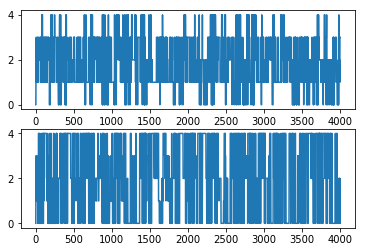

In [101]:
#### time series of clusters


fig, ax = plt.subplots(2,1)
ax[0].plot(labels_test[:4000])
ax[1].plot(labels_test[4000:])
plt.show()

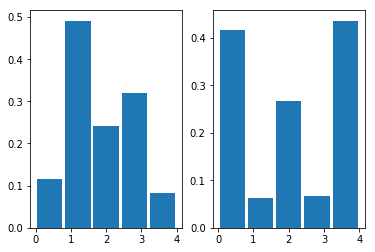

In [103]:
#### histogram of clusters

import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,2)
ax[0].hist(labels_test[:4000],bins=5, rwidth=0.9, density=True)
ax[1].hist(labels_test[4000:], bins =5, rwidth=0.9, density=True)
plt.show()

In [107]:
train_E= np.vstack((train_E_1, train_E_2))
train_I= np.vstack((train_I_1, train_I_2))


"""sub='180432'
train_E, train_I, test_E, test_I = get_EI(sub, out_dir)"""

analytic_signal_train= train_E +train_I*1j#scipy.signal.hilbert(ts,axis=0)
Leads_train = get_leads_ts(analytic_signal_train, 1)

X_train = np.array(Leads_train)
labels_train, centers_train = leads_train(X_train, 5)

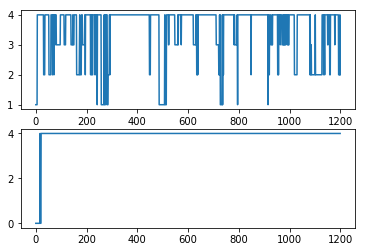

In [108]:
#### time series of clusters


fig, ax = plt.subplots(2,1)
ax[0].plot(labels_train[:1200])
ax[1].plot(labels_train[1200:])
plt.show()

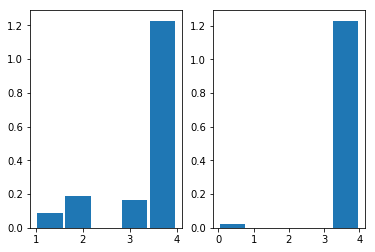

In [109]:
#### histogram of clusters

import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,2)
ax[0].hist(labels_train[:1200],bins=5, rwidth=0.9, density=True)
ax[1].hist(labels_train[1200:], bins =5, rwidth=0.9, density=True)
plt.show()

In [111]:
import os

In [119]:
sc_base_dir = '/gerda/mcintosh_lab/jgriffiths/hcp_wuminn_l2k8_tracks_conmats/data/results/hcp_wuminn/tractography/dipy/l2k8/'
ts_base_dir='/gerda/mcintosh_lab/jgriffiths/hcp_wuminn_l2k8_rsfmri_ts/data/results/'


subIDs_list = subs=[sub for sub in os.listdir(sc_base_dir) if os.path.isdir(sc_base_dir+sub)]


In [120]:
train_E=[]
train_I=[]
for i in range(len(subIDs_list)):
    sub =subIDs_list[i]
    print(i, sub)
    sc_file = sc_base_dir+sub+'/dsi_sd4/sub-'+sub+'_roisc33dwispace/weights.txt'
    ts_file = ts_base_dir+sub+'_rfMRI_REST1_LR_hpc200_clean__l2k8_sc33_ts.pkl'
    if os.path.isfile(sc_file) and os.path.isfile(ts_file):
        train_E_sub, train_I_sub, test_E_sub, test_I_sub = get_EI(sub, out_dir)
        train_E.append(train_E_sub)
        train_I.append(train_I_sub)
train_E = np.concatenate(train_E, axis=0)
train_I = np.concatenate(train_I, axis=0)
        


0 156233
1 209329
2 154532
3 172332
4 181131
5 317332
6 196750
7 196144
8 231928
9 579867
10 146432
11 148941
12 100307
13 709551
14 155938
15 198451
16 311320
17 385450
18 173637
19 181636
20 290136
21 198653
22 157336
23 121921
24 145127
25 567961
26 492754
27 562446
28 200210
29 151223
30 872158
31 579665
32 548250
33 198350
34 297655
35 295146
36 561444
37 183337
38 559053
39 519950
40 220721
41 197550
42 179952
43 151526
44 191033
45 177342
46 156536
47 298051
48 570243
49 154229
50 512835
51 257542
52 529549
53 173738
54 214423
55 177746
56 171532
57 480141
58 285446
59 176441
60 280941
61 115017
62 156435
63 965771
64 448347
65 173233
66 173536
67 904044
68 175035
69 150928
70 316835
71 211215
72 171633
73 305830
74 926862
75 547046
76 154936
77 127327
78 318637
79 158338
80 910241
81 191336
82 286650
83 753251
84 486759
85 153025
86 200008
87 803240
88 156637
89 149842
90 159744
91 299154
92 957974
93 671855
94 173940
95 465852
96 150423
97 599469
98 199251
99 816653
100 158843

In [122]:
np.savetxt(out_dir+'HCP_alltrain_E.txt', train_E)
np.savetxt(out_dir+'HCP_alltrain_I.txt', train_I)

In [123]:
analytic_signal_train= train_E +train_I*1j#scipy.signal.hilbert(ts,axis=0)
Leads_train = get_leads_ts(analytic_signal_train, 1)

X_train = np.array(Leads_train)
labels_train, centers_train = leads_train(X_train, 5)

np.savetxt(out_dir+'HCP_alllabels.txt', labels_train)

In [132]:
np.savetxt(out_dir+'HCP_1st_evs.txt', X_train)

In [129]:
labels_train, centers_train = leads_train(X_train, 10)

np.savetxt(out_dir+'HCP_alllabels_10.txt', labels_train)

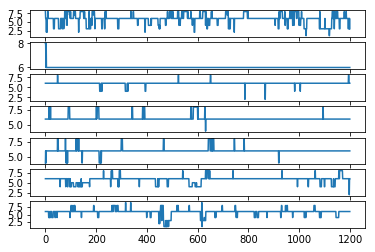

In [131]:
#### time series of clusters


fig, ax = plt.subplots(7,1)
ax[0].plot(labels_train[:1200])
ax[1].plot(labels_train[1200:2*1200])
ax[2].plot(labels_train[2*1200:3*1200])
ax[3].plot(labels_train[3*1200:4*1200])
ax[4].plot(labels_train[4*1200:5*1200])
ax[5].plot(labels_train[5*1200:6*1200])
ax[6].plot(labels_train[6*1200:7*1200])
plt.show()

In [133]:
X_train = np.array(Leads_train)
Leads_train = get_leads_ts(analytic_signal_train, 2)
labels_train, centers_train = leads_train(X_train, 5)

np.savetxt(out_dir+'HCP_alllabels_5c_2ndev.txt', labels_train)
np.savetxt(out_dir+'HCP_2nd_evs.txt', X_train)

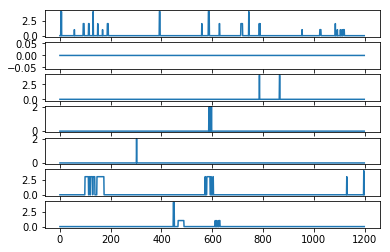

In [134]:
#### time series of clusters


fig, ax = plt.subplots(7,1)
ax[0].plot(labels_train[:1200])
ax[1].plot(labels_train[1200:2*1200])
ax[2].plot(labels_train[2*1200:3*1200])
ax[3].plot(labels_train[3*1200:4*1200])
ax[4].plot(labels_train[4*1200:5*1200])
ax[5].plot(labels_train[5*1200:6*1200])
ax[6].plot(labels_train[6*1200:7*1200])
plt.show()

In [135]:
labels_train, centers_train = leads_train(X_train, 10)

np.savetxt(out_dir+'HCP_alllabels_10c_2ndev.txt', labels_train)

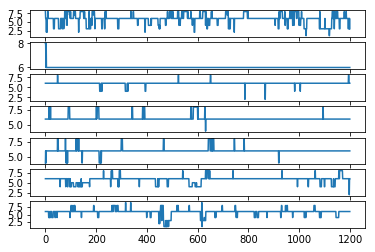

In [136]:
#### time series of clusters


fig, ax = plt.subplots(7,1)
ax[0].plot(labels_train[:1200])
ax[1].plot(labels_train[1200:2*1200])
ax[2].plot(labels_train[2*1200:3*1200])
ax[3].plot(labels_train[3*1200:4*1200])
ax[4].plot(labels_train[4*1200:5*1200])
ax[5].plot(labels_train[5*1200:6*1200])
ax[6].plot(labels_train[6*1200:7*1200])
plt.show()

In [ ]:
a